In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import csv
from torch import nn
from sklearn.utils import class_weight
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

torch.manual_seed(0)

DATASET = 'cryptobench'
DATA_PATH = f'/home/skrhakv/cryptic-nn/data/{DATASET}'
ESM_EMBEDDINGS_PATH = f'{DATA_PATH}/embeddings'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Load the dataset

In [5]:
is_in_p2rank = ['1arlA', '1bk2A', '1bzjA', '1cwqA', '1dq2A', '1e6kA', '1evyA', '1g59A', '1h13A', '1i7nA', '1k47D', '1ksgB', '1kx9A', '1kxrA', '1lbeB', '1m5wD', '1nd7A', '1p4oB', '1p4vA', '1p9oA', '1pu5C', '1q4kA', '1rjbA', '1rtcA', '1se8A', '1ukaA', '1uteA', '1vsnA', '1x2gC', '1xgdA', '1xjfA', '1xqvA', '1xtcA', '1zm0A', '2akaA', '2d05A', '2dfpA', '2femA', '2fhzB', '2h7sA', '2i3aD', '2i3rA', '2iytA', '2phzA', '2pkfA', '2pwzG', '2qbvA', '2rfjB', '2v6mD', '2vl2C', '2vqzF', '2vyrA', '2w8nA', '2x47A', '2xsaA', '2zj7A', '3a0xA', '3bjpA', '3f4kA', '3flgA', '3fzoA', '3gdgB', '3h8aB', '3i8sB', '3idhA', '3jzgA', '3k01A', '3ly8A', '3mwgB', '3n4uA', '3nx1B', '3pbfA', '3rwvA', '3st6C', '3t8bA', '3tpoA', '3ugkA', '3uyiA', '3v55A', '3vgmA', '3w90A', '3wb9C', '4aemA', '4amvB', '4bg8A', '4cmwB', '4dncB', '4e1yA', '4fkmB', '4gpiC', '4gv9A', '4hyeA', '4ikvA', '4ilgA', '4j4eF', '4jaxF', '4jfrC', '4kmyA', '4mwiA', '4nzvB', '4oqoB', '4p2fA', '4qvkB', '4r0xA', '4rvtB', '4ttpA', '4uc8A', '4uumA', '4zm7A', '4zoeB', '5acvB', '5b0eB', '5cazA', '5e0vA', '5ey7B', '5hijA', '5htoE', '5i3tE', '5ighA', '5kcgB', '5locA', '5o8bA', '5sc2A', '5tc0B', '5tviV', '5uxaA', '5wbmB', '5yhbA', '5yj2C', '5yqpA', '5ysbB', '5z18C', '5zj4D', '6a98C', '6btyB', '6cqeB', '6du4A', '6eqjA', '6f52A', '6fc2C', '6fgjB', '6g6yA', '6heiA', '6isuA', '6jq9B', '6kscA', '6n5jB', '6neiB', '6o4fH', '6tx0B', '6vleA', '6w10A', '7c48A', '7c63A', '7de1A', '7e5qB', '7f2mB', '7f4yB', '7kayA', '7nc8D', '7ndlB', '7nlxA', '7o1iA', '7qoqA', '7qzrD', '7v8kB', '7w19A', '7x0fA', '7x0gB', '7x0iB', '7xgfE', '7yjcA', '8aeqA', '8aqiB', '8b9pA', '8breB', '8h27A', '8i84B', '8iasB', '8j11X', '8onnE', '8u3nA', '8vxuB', '9atcA']

class SequenceCryptoBenchDataset(Dataset):
    def __init__(self, _Xs, _Ys, p2rank_evaluation=False):
        _Xs_list = []
        _Ys_list = []
        for key, _ in _Xs.items():
            if not key in is_in_p2rank and p2rank_evaluation:
                continue

            # print(f'Processing {key} ...')
            _Xs_list.append(_Xs[key])
            _Ys_list.append(_Ys[key])

        print('Concatenating ...')
        Xs_list = np.concatenate(_Xs_list, axis=0)
        Ys_list = np.concatenate(_Ys_list, axis=0)

        print('Converting to torch tensor ...')
        self.Xs = torch.tensor(Xs_list, dtype=torch.float32)
        self.Ys = torch.tensor(Ys_list, dtype=torch.int64)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y

def process_sequence_dataset(annotation_path, embeddings_paths):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            sequence = row[4]

            if row[3] == '':
                continue
            
            # load the precomputed embedding
            if id not in Xs:
                for embeddings_path in embeddings_paths:
                    filename = id + '.npy'
                    embedding = np.load(f'{embeddings_path}/{filename}')
                    if id not in Xs:
                        Xs[id] = embedding
                    else:
                        Xs[id] = np.concatenate((Xs[id], embedding), axis = 1)
                    

            # load the annotations denoting whether particular residue is binding or not
            # we use binary annotation: 0=non-binding; 1=binding
            if id not in Ys:
                Ys[id] = np.zeros(embedding.shape[0])
            for (aa, residue_idx) in [(residue[0], int(residue[1:])) for residue in row[3].split(' ')]:
                assert sequence[residue_idx] == aa
                Ys[id][residue_idx] = 1

    return Xs, Ys

In [3]:
DECISION_THRESHOLD = 0.95
DROPOUT = 0.3
LAYER_WIDTH = 256
# ESM2_DIM = 320
# ESM2_DIM  = 1280
ESM2_DIM  = 2560
class CryptoBenchClassifier(nn.Module):
    def __init__(self, input_dim=ESM2_DIM):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=LAYER_WIDTH)
        self.dropout1 = nn.Dropout(DROPOUT)

        self.layer_2 = nn.Linear(in_features=LAYER_WIDTH, out_features=LAYER_WIDTH)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.layer_3 = nn.Linear(in_features=LAYER_WIDTH, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.dropout2(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x)))))))


def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

torch.manual_seed(42)

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, bce_loss=nn.functional.binary_cross_entropy_with_logits, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # controls class imbalance
        self.gamma = gamma  # focuses on hard examples
        self.reduction = reduction
        self.bce_loss = bce_loss

    def forward(self, inputs, targets):
        # Calculate Binary Cross-Entropy Loss for each sample
        BCE_loss = self.bce_loss(inputs, targets)
        
        # Compute pt (model confidence on true class)
        pt = torch.exp(-BCE_loss)
        
        # Apply the focal adjustment
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        # Apply reduction (mean, sum, or no reduction)
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
        
def train(model, optimizer, epochs, batch_size, train_dataset, test_dataset):
    model = model.to(device)

    # Create an optimizer
    _, y_train = train_dataset[:]
    X_test, y_test, = test_dataset[:]

    # compute class weights (because the dataset is heavily imbalanced)
    class_weights = compute_class_weights(y_train.numpy()).to(device)
    print(f'Class weights: ', class_weights)
    # BCEWithLogitsLoss - sigmoid is already built-in!

    loss_fn = nn.BCEWithLogitsLoss(pos_weight=8 * class_weights[1])
    # loss_fn = FocalLoss(alpha=1, gamma=2, bce_loss=loss_fn)

    X_test, y_test = X_test.to(device), y_test.to(device).float()

    train_losses, test_losses = [], []

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        #
        # TEST
        #
        model.eval()
        with torch.inference_mode():

            test_logits = model(X_test).squeeze()
            # test_pred = torch.round(torch.sigmoid(test_logits))
            test_pred = (torch.sigmoid(test_logits)>DECISION_THRESHOLD).float()

            test_loss = loss_fn(test_logits,
                                y_test)
            test_losses.append(test_loss.cpu().detach().numpy())

            # compute metrics on test dataset
            test_acc = accuracy_fn(y_true=y_test,
                                   y_pred=test_pred)
            
            fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())

            f1 = metrics.f1_score(y_test.cpu().numpy(), test_pred.cpu().numpy(), average='weighted')

            precision, recall, thresholds = metrics.precision_recall_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            auprc = metrics.auc(recall, precision)


        #
        # TRAIN
        #
        batch_losses = []
        for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).float()

            model.train()

            y_logits = model(x_batch).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = loss_fn(y_logits,
                           y_batch)
            acc = accuracy_fn(y_true=y_batch,
                              y_pred=y_pred)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            batch_losses.append(loss.cpu().detach().numpy())

        train_losses.append(sum(batch_losses) / len(batch_losses))
        #if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(test_pred)}")

    plt.plot(train_losses,label="train loss over epochs")
    plt.plot(test_losses,label="test loss over epochs")
    plt.legend()
    plt.show()

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return fpr, tpr, roc_auc

# Train a classifier on APO sequences and evaluate on APO sequences

In [7]:
# Xs_train_apo, Ys_train_apo = process_sequence_dataset(f'{DATA_PATH}/train.txt', [ESM_EMBEDDINGS_PATH])
Xs_train_apo, Ys_train_apo = process_sequence_dataset(f'/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', [ESM_EMBEDDINGS_PATH])
train_dataset_apo = SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

# Xs_test_apo, Ys_test_apo = process_sequence_dataset(f'{DATA_PATH}/test.txt', [ESM_EMBEDDINGS_PATH])
Xs_test_apo, Ys_test_apo = process_sequence_dataset(f'/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', [ESM_EMBEDDINGS_PATH])
test_dataset_apo = SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo)

Concatenating ...
Converting to torch tensor ...
Concatenating ...
Converting to torch tensor ...


In [ ]:
# new focal loss - on 650M model, reduction=mean:
# alpha=0.75, gamma=5:          Epoch: 8 | Loss: 0.00533, Accuracy: 86.71% | Test loss: 0.00931, AUC: 0.8680725268036404, MCC: 0.3585423206673791, sum: 8519.0
# alpha=0.5,  gamma=2:          Epoch: 6 | Loss: 0.05956, Accuracy: 87.75% | Test loss: 0.06469, AUC: 0.8680178910280074, MCC: 0.36506595417709725, sum: 7795.0
# alpha=0.2, gamma=2:           Epoch: 8 | Loss: 0.01802, Accuracy: 86.86% | Test loss: 0.02570, AUC: 0.8686128854086212, MCC: 0.35956359716831804, sum: 8419.0
# alpha=1, gamma=2:             Epoch: 4 | Loss: 0.09742, Accuracy: 87.57% | Test loss: 0.12833, AUC: 0.8685099513294228, MCC: 0.3670968650138782, sum: 7968.0

# reduction=sum:
# alpha=0.2, gamma=2:           Epoch: 4 | Loss: 0.01948, Accuracy: 87.57% | Test loss: 0.02566, AUC: 0.8685299031897674, MCC: 0.36662209991628, sum: 7962.0
# alpha=1, gamma=2:             Epoch: 8 | Loss: 0.08996, Accuracy: 86.89% | Test loss: 0.12859, AUC: 0.8685462634131781, MCC: 0.35969782033831377, sum: 8400.0

# BASELINE - BCEwithLogitsLoss: Epoch: 14 | Loss: 0.63262, Accuracy: 86.67% | Test loss: 0.61641, AUC: 0.8647, MCC: 0.3482002, sum: 8925.0


Class weights:  tensor([0.5303, 8.7481], device='cuda:0')
Epoch: 0 | Loss: 2.05755, Accuracy: 94.32% | Test loss: 3.31052, AUC: 0.5115, MCC: 0.0000, F1: 0.9156, AUPRC: 0.0617, sum: 0.0
Epoch: 1 | Loss: 1.69637, Accuracy: 93.70% | Test loss: 1.98590, AUC: 0.8164, MCC: 0.1870, F1: 0.9231, AUPRC: 0.2231, sum: 1166.0
Epoch: 2 | Loss: 1.55590, Accuracy: 92.99% | Test loss: 1.68681, AUC: 0.8654, MCC: 0.3697, F1: 0.9311, AUPRC: 0.3437, sum: 3409.0
Epoch: 3 | Loss: 1.38803, Accuracy: 92.24% | Test loss: 1.62494, AUC: 0.8727, MCC: 0.3888, F1: 0.9280, AUPRC: 0.3651, sum: 4325.0
Epoch: 4 | Loss: 1.34670, Accuracy: 91.61% | Test loss: 1.62850, AUC: 0.8735, MCC: 0.3925, F1: 0.9246, AUPRC: 0.3681, sum: 4940.0
Epoch: 5 | Loss: 1.36758, Accuracy: 91.37% | Test loss: 1.64203, AUC: 0.8737, MCC: 0.3933, F1: 0.9232, AUPRC: 0.3724, sum: 5166.0
Epoch: 6 | Loss: 1.17106, Accuracy: 91.29% | Test loss: 1.69681, AUC: 0.8708, MCC: 0.3935, F1: 0.9228, AUPRC: 0.3736, sum: 5234.0


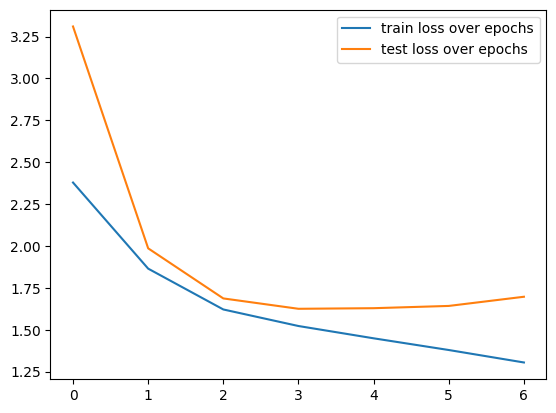

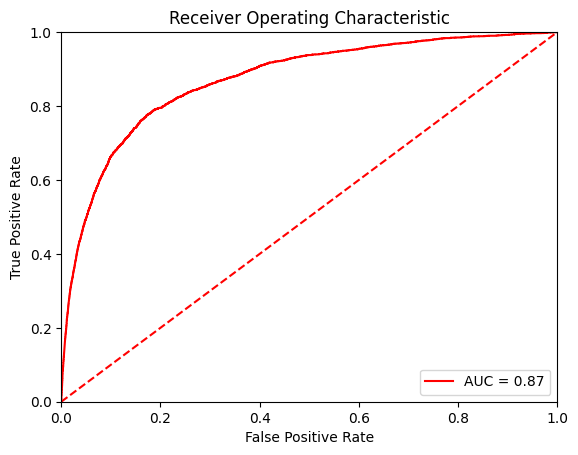

In [5]:
model_3 = CryptoBenchClassifier().to(device)
optimizer = torch.optim.AdamW(params=model_3.parameters(),
                            lr=0.0001)


fpr_3, tpr_3, roc_auc_3 = train(model_3, optimizer, epochs=7, batch_size=2048, 
      train_dataset=train_dataset_apo, test_dataset=test_dataset_apo)

# Focal alpha=0.25, gamma=20
# Epoch: 10 | Loss: 0.01287, Accuracy: 94.37% | Test loss: 0.01320, AUC: 0.762610765510114, MCC: -0.0017429694370834372, sum: 3.0

# Focal alpha=0.1, gamma=2
# Epoch: 10 | Loss: 0.00515, Accuracy: 94.37% | Test loss: 0.00528, AUC: 0.7625907291165689, MCC: -0.0017429694370834372, sum: 3.0

# Focal alpha=0.1, gamma=5
# Epoch: 10 | Loss: 0.00072, Accuracy: 94.39% | Test loss: 0.00074, AUC: 0.7706074770785728, MCC: 0.056801471378340455, sum: 39.0

# Focal alpha=0.01, gamma=5
# Epoch: 10 | Loss: 0.00007, Accuracy: 94.38% | Test loss: 0.00007, AUC: 0.7694545779808044, MCC: 0.04585515596298591, sum: 31.0

# Focal alpha=0.0.75, gamma=5
# Epoch: 10 | Loss: 0.00543, Accuracy: 94.39% | Test loss: 0.00552, AUC: 0.7707493256993421, MCC: 0.0578821304422823, sum: 41.0

# BCE
# Epoch: 10 | Loss: 0.72529, Accuracy: 85.76% | Test loss: 0.75325, AUC: 0.7793131974389598, MCC: 0.22880818993443539, sum: 8123.0



# BCE on train (first three folds) and val (last fold):
# 8M:                                   Epoch: 39 | Loss: 0.72870, Accuracy: 85.08% | Test loss: 0.72930, AUC: 0.7968, MCC: 0.2499260, sum: 8895.0
# 650M:                                 Epoch: 14 | Loss: 0.63262, Accuracy: 86.67% | Test loss: 0.61641, AUC: 0.8647, MCC: 0.3482002, sum: 8925.0
# 650M finetuned:                       Epoch: 1 | Loss: 0.32123, Accuracy: 80.60% | Test loss: 0.65471, AUC:  0.8741, MCC: 0.3266976, sum: 12822.0
# 3B:                                   Epoch: 10 | Loss: 0.53802, Accuracy: 87.63% | Test loss: 0.61661, AUC: 0.8647, MCC: 0.3541880, sum: 8222.0


# BCE on full train and evaluated on test:
# 8M:                                   Epoch: 17 | Loss: 0.63510, Accuracy: 87.49% | Test loss: 0.72767, AUC: 0.798512, MCC: 0.27700, sum: 6936.0
# 650M:                                 Epoch: 5 | Loss: 0.56699, Accuracy: 87.64% | Test loss: 0.61546, AUC: 0.8673022, MCC: 0.36450, sum: 7875.0
# 650M finetuned (manual impl.):        Epoch: 1 | Loss: 0.34253, Accuracy: 91.27% | Test loss: 0.59555, AUC: 0.8784789, MCC: 0.41902, sum: 5562.0
# 650M finetuned with LoRA:             Epoch: 3 | Loss: 0.93123, Accuracy: 86.97% | Test loss: 0.63380, AUC: 0.8560885, MCC: 0.35940, sum: 8330.0
# 650M finetuned - distances+ligysis:   Epoch: 1 | Loss: 0.47167, Accuracy: 89.55% | Test loss: 0.80418, AUC: 0.8841012, MCC: 0.42225, sum: 7076.0
# 3B:                                   Epoch: 3 | Loss: 0.54364, Accuracy: 86.58% | Test loss: 0.59630, AUC: 0.8761860, MCC: 0.37719, sum: 8860.0
# 3B finetuned (batchsize=1, half):     Epoch: 2 | Loss: 0.16598, Accuracy: 89.82% | Test loss: 0.56725, AUC: 0.8894166, MCC: 0.42104, sum: 2048.0
# ESM++ finetuned:                      Epoch: 1 | Loss: 0.38677, Accuracy: 82.28% | Test loss: 0.62088, AUC: 0.8778704, MCC: 0.34509, sum: 11621.0
# ESM++ finetuned - distances+ligysis:  Epoch: 1 | Loss: 0.33474, Accuracy: 90.97% | Test loss: 0.54741, AUC: 0.8948266, MCC: 0.44853, sum: 6194.0
# ESMC-300M finetuned:                  Epoch: 4 | Loss: 0.18427, Accuracy: 91.07% | Test loss: 0.66096, AUC: 0.8701985, MCC: 0.40720, sum: 5593.0
# ESMC-600M finetuned:                  Epoch: 2 | Loss: 0.20186, Accuracy: 89.83% | Test loss: 0.59128, AUC: 0.8789400, MCC: 0.41237, sum: 6716.0
# ESMC-600M finetuned-distances+ligysis:Epoch: 1 | Loss: 0.33474, Accuracy: 90.97% | Test loss: 0.54741, AUC: 0.8948266, MCC: 0.44853, sum: 6194.0
# 3B finetuned - distances + ligysis:   Epoch: 3 | Loss: 0.39817, Accuracy: 88.08% | Test loss: 0.54287, AUC: 0.8954315, MCC: 0.42774, sum: 35.0


## Replicate for p2rank eval subset:

Concatenating ...
Converting to torch tensor ...
Concatenating ...
Converting to torch tensor ...
Class weights:  tensor([0.5303, 8.7481], device='cuda:0')
Epoch: 0 | Loss: 2.05755, Accuracy: 94.32% | Test loss: 3.31052, AUC: 0.5115, MCC: 0.0000, F1: 0.9156, AUPRC: 0.0617, sum: 0.0
Epoch: 1 | Loss: 1.69637, Accuracy: 93.70% | Test loss: 1.98590, AUC: 0.8164, MCC: 0.1870, F1: 0.9231, AUPRC: 0.2231, sum: 1166.0
Epoch: 2 | Loss: 1.55590, Accuracy: 92.99% | Test loss: 1.68681, AUC: 0.8654, MCC: 0.3697, F1: 0.9311, AUPRC: 0.3437, sum: 3409.0
Epoch: 3 | Loss: 1.38803, Accuracy: 92.24% | Test loss: 1.62494, AUC: 0.8727, MCC: 0.3888, F1: 0.9280, AUPRC: 0.3651, sum: 4325.0
Epoch: 4 | Loss: 1.34670, Accuracy: 91.61% | Test loss: 1.62850, AUC: 0.8735, MCC: 0.3925, F1: 0.9246, AUPRC: 0.3681, sum: 4940.0
Epoch: 5 | Loss: 1.36758, Accuracy: 91.37% | Test loss: 1.64203, AUC: 0.8737, MCC: 0.3933, F1: 0.9232, AUPRC: 0.3724, sum: 5166.0
Epoch: 6 | Loss: 1.17106, Accuracy: 91.29% | Test loss: 1.69681, AU

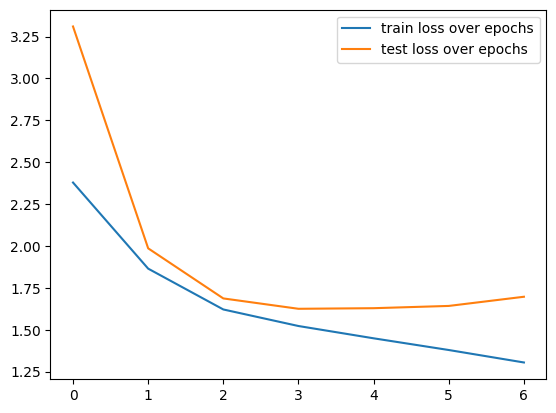

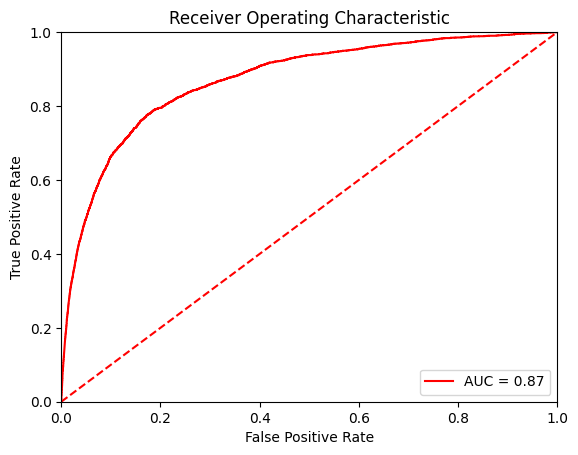

In [6]:
# Xs_train_apo, Ys_train_apo = process_sequence_dataset(f'{DATA_PATH}/train.txt', [ESM_EMBEDDINGS_PATH])
Xs_train_apo, Ys_train_apo = process_sequence_dataset(f'/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', [ESM_EMBEDDINGS_PATH])
train_dataset_apo = SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

# Xs_test_apo, Ys_test_apo = process_sequence_dataset(f'{DATA_PATH}/test.txt', [ESM_EMBEDDINGS_PATH])
Xs_test_apo, Ys_test_apo = process_sequence_dataset(f'/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', [ESM_EMBEDDINGS_PATH])
test_dataset_apo = SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo, p2rank_evaluation=True)

model_3 = CryptoBenchClassifier().to(device)
optimizer = torch.optim.AdamW(params=model_3.parameters(),
                            lr=0.0001)


fpr_3, tpr_3, roc_auc_3 = train(model_3, optimizer, epochs=7, batch_size=2048, 
      train_dataset=train_dataset_apo, test_dataset=test_dataset_apo)



In [ ]:
# save the model:
OUTPUT_PATH = '/home/skrhakv/cryptic-nn/data/cryptobench/models/model-650M.pt'
torch.save(model_3, OUTPUT_PATH)
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save(OUTPUT_PATH) # Save

In [ ]:
# predict for 7qoqA

test_logits = model_3(torch.tensor(np.load('/home/skrhakv/cryptic-nn/data/cryptobench/650M-embeddings/7qoqA.npy'), dtype=torch.float32).to(device)).squeeze()
test_pred = torch.round(torch.sigmoid(test_logits))
test_pred


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [9]:
from sklearn.preprocessing import StandardScaler

class MultitaskSequenceCryptoBenchDataset(Dataset):
    def __init__(self, _Xs, _Ys_CBS, _Ys_distances, scaler=None):
        
        _Xs_list = []
        _Ys_CBS_list = []
        _Ys_distances_list = []
        for key, _ in _Xs.items():
            print(f'Processing {key} ...')
            _Xs_list.append(_Xs[key])
            _Ys_CBS_list.append(_Ys_CBS[key])
            _Ys_distances_list.append(_Ys_distances[key])

        print('Concatenating ...')
        Xs_list = np.concatenate(_Xs_list, axis=0)
        Ys_CBS_list = np.concatenate(_Ys_CBS_list, axis=0)
        Ys_distances_list = np.concatenate(_Ys_distances_list, axis=0)

        print('Rescaling the distances ...')
        if not scaler:
            self.scaler = StandardScaler()
            self.scaler.fit(Ys_distances_list.reshape(-1, 1))
        else:
            self.scaler = scaler
        
        Ys_distances_list = self.scaler.transform(Ys_distances_list.reshape(-1, 1)).reshape(1, -1)[0]
        
        print('Converting to torch tensor ...')
        self.Xs = torch.tensor(Xs_list, dtype=torch.float32)
        self.Ys_CBS = torch.tensor(Ys_CBS_list, dtype=torch.int16)
        self.Ys_distances = torch.tensor(Ys_distances_list, dtype=torch.float32)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys_CBS)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y_CBS = self.Ys_CBS[idx]
        y_distance = self.Ys_distances[idx]
        return x, y_CBS, y_distance

def multitask_process_sequence_dataset(annotation_path, embeddings_paths, distances_path):
    Xs = {}
    Ys_CBS = {}
    Ys_distances = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            sequence = row[4]

            if row[3] == '':
                continue
            
            # load the precomputed embedding
            if id not in Xs:
                for embeddings_path in embeddings_paths:
                    filename = id + '.npy'
                    embedding = np.load(f'{embeddings_path}/{filename}')
                    if id not in Xs:
                        Xs[id] = embedding
                    else:
                        Xs[id] = np.concatenate((Xs[id], embedding), axis = 1)
                    

            # load the annotations denoting whether particular residue is binding or not
            # we use binary annotation: 0=non-binding; 1=binding
            if id not in Ys_CBS:
                Ys_CBS[id] = np.zeros(embedding.shape[0])
                distances = np.load(f'{distances_path}/{id}.npy')
                # set the unknown value (-1) to something more reasonable:
                distances[distances == -1] = 0.5
                Ys_distances[id] = distances

                assert len(Ys_CBS[id]) == len(Ys_distances[id])
            
            for (aa, residue_idx) in [(residue[0], int(residue[1:])) for residue in row[3].split(' ')]:
                assert sequence[residue_idx] == aa
                Ys_CBS[id][residue_idx] = 1

    return Xs, Ys_CBS, Ys_distances


DROPOUT = 0.5
LAYER_WIDTH = 300
ESM2_DIM = 2560

class MultitaskCryptoBenchClassifier(nn.Module):
    def __init__(self, input_dim=ESM2_DIM):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=LAYER_WIDTH)
        self.dropout1 = nn.Dropout(DROPOUT)

        self.layer_2 = nn.Linear(in_features=LAYER_WIDTH, out_features=LAYER_WIDTH)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.layer_3_CBS = nn.Linear(in_features=LAYER_WIDTH, out_features=1)
        self.layer_3_distance = nn.Linear(in_features=LAYER_WIDTH, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Intersperse the ReLU activation function between layers
        x = self.dropout2(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x))))))
        return self.layer_3_CBS(x), self.layer_3_distance(x)
    


In [10]:
DISTANCES_PATH = f'/home/skrhakv/cryptic-nn/data/{DATASET}/residue-distances'

Xs_train, Ys_train_CBS, Ys_train_distances = multitask_process_sequence_dataset(f'{DATA_PATH}/train.txt', [ESM_EMBEDDINGS_PATH], DISTANCES_PATH)
train_dataset = MultitaskSequenceCryptoBenchDataset(Xs_train, Ys_train_CBS, Ys_train_distances)

Xs_test, Ys_test_CBS, Ys_test_distances = multitask_process_sequence_dataset(f'{DATA_PATH}/test.txt', [ESM_EMBEDDINGS_PATH], DISTANCES_PATH)
test_dataset = MultitaskSequenceCryptoBenchDataset(Xs_test, Ys_test_CBS, Ys_test_distances, scaler=train_dataset.scaler)


Processing 1jpmA ...
Processing 2yx7A ...
Processing 2e1cA ...
Processing 1qhtA ...
Processing 6cjfA ...
Processing 2w6rA ...
Processing 5x6zD ...
Processing 1nkoA ...
Processing 5caeB ...
Processing 1macB ...
Processing 4dmzB ...
Processing 4gvrA ...
Processing 6kx4A ...
Processing 4ok2B ...
Processing 4ljpA ...
Processing 5v49A ...
Processing 7l8qA ...
Processing 4m23B ...
Processing 7se6A ...
Processing 4brrE ...
Processing 1vjuB ...
Processing 1nwhB ...
Processing 5uzvZ ...
Processing 4jycC ...
Processing 1mufA ...
Processing 6lgyA ...
Processing 3p08B ...
Processing 1l0wB ...
Processing 6cy1A ...
Processing 6ksuA ...
Processing 1e5lB ...
Processing 8c3uA ...
Processing 7btcB ...
Processing 7oueA ...
Processing 3vskB ...
Processing 4z4lA ...
Processing 7s5gA ...
Processing 3l15A ...
Processing 8jisR ...
Processing 7ciuA ...
Processing 6dauE ...
Processing 2zcoA ...
Processing 1m1zA ...
Processing 3vjbD ...
Processing 1wxeA ...
Processing 5h61B ...
Processing 5fioB ...
Processing 5m

Class weights:  tensor([0.5303, 8.7481], device='cuda:0')
Epoch: 0 | Loss: 1.0462, Distance loss: 0.3920, CBS loss: 0.6542, Accuracy: 5.68% | Test loss: 1.0121, AUC: 0.5392, MCC: 0.0000, sum: 55572.0
Epoch: 1 | Loss: 0.9205, Distance loss: 0.3655, CBS loss: 0.5550, Accuracy: 88.42% | Test loss: 0.6268, AUC: 0.8650, MCC: 0.3712, sum: 7352.0
Epoch: 2 | Loss: 1.0006, Distance loss: 0.3685, CBS loss: 0.6321, Accuracy: 87.83% | Test loss: 0.5927, AUC: 0.8767, MCC: 0.3858, sum: 8000.0
Epoch: 3 | Loss: 0.8679, Distance loss: 0.3802, CBS loss: 0.4877, Accuracy: 86.77% | Test loss: 0.5944, AUC: 0.8762, MCC: 0.3791, sum: 8738.0
Epoch: 4 | Loss: 0.8120, Distance loss: 0.3577, CBS loss: 0.4543, Accuracy: 87.56% | Test loss: 0.5930, AUC: 0.8771, MCC: 0.3835, sum: 8180.0
Epoch: 5 | Loss: 0.9005, Distance loss: 0.3502, CBS loss: 0.5503, Accuracy: 87.80% | Test loss: 0.5970, AUC: 0.8758, MCC: 0.3830, sum: 7990.0
Epoch: 6 | Loss: 0.7619, Distance loss: 0.3333, CBS loss: 0.4285, Accuracy: 88.65% | Test 

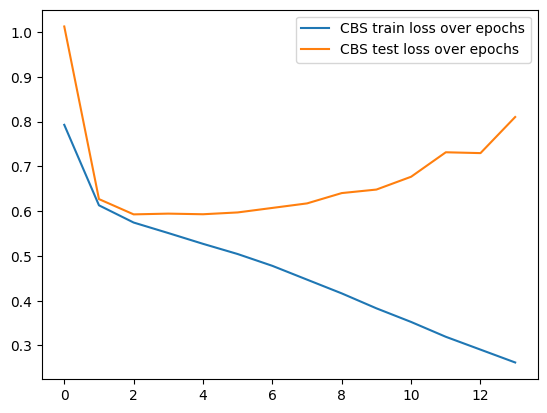

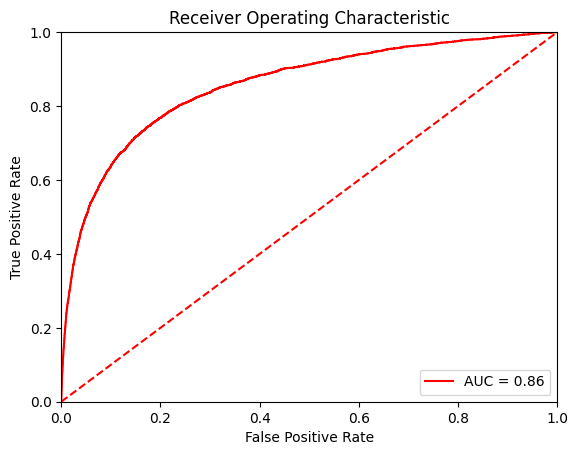

In [ ]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(pred + 1, actual + 1))

class MSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return self.mse(torch.log(pred + 1), torch.log(actual + 1))

def multitask_train(model, optimizer, epochs, batch_size, train_dataset, test_dataset):
    model = model.to(device)

    # Create an optimizer
    _, y_train_cbs, _ = train_dataset[:]
    X_test, y_test_cbs, _ = test_dataset[:]

    # compute class weights (because the dataset is heavily imbalanced)
    cbs_class_weights = compute_class_weights(y_train_cbs.numpy()).to(device)
    print(f'Class weights: ', cbs_class_weights)
    # BCEWithLogitsLoss - sigmoid is already built-in!
    cbs_loss_fn = nn.BCEWithLogitsLoss(pos_weight=cbs_class_weights[1])
    distances_loss_fn = RMSLELoss() # TODO: MSLE? 

    X_test, y_test_cbs = X_test.to(device), y_test_cbs.to(device).float()

    train_losses, test_losses = [], []

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        #
        # TEST
        #
        model.eval()
        with torch.inference_mode():

            test_logits, _ = model(X_test)
            test_logits = test_logits.squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = cbs_loss_fn(test_logits,
                                y_test_cbs)
            test_losses.append(test_loss.cpu().detach().numpy())

            # compute metrics on test dataset
            test_acc = accuracy_fn(y_true=y_test_cbs,
                                   y_pred=test_pred)
            fpr, tpr, thresholds = metrics.roc_curve(y_test_cbs.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(y_test_cbs.cpu().numpy(), test_pred.cpu().numpy())

        #
        # TRAIN
        #
        batch_losses = []
        for id_batch, (x_batch, y_batch_cbs, y_batch_distances) in enumerate(train_dataloader):

            x_batch = x_batch.to(device)
            y_batch_cbs = y_batch_cbs.to(device).float()
            y_batch_distances = y_batch_distances.to(device).float()
            model.train()

            y_logits_cbs, y_logits_distance = model(x_batch)
            y_logits_cbs, y_logits_distance = y_logits_cbs.squeeze(), y_logits_distance.squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits_cbs))

            cbs_loss = cbs_loss_fn(y_logits_cbs,
                           y_batch_cbs)
            distance_loss = distances_loss_fn(y_logits_distance, y_batch_distances)

            loss = cbs_loss + distance_loss

            acc = accuracy_fn(y_true=y_batch_cbs,
                              y_pred=y_pred)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            batch_losses.append(cbs_loss.cpu().detach().numpy())

        train_losses.append(sum(batch_losses) / len(batch_losses))
        #if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Distance loss: {distance_loss:.4f}, CBS loss: {cbs_loss:.4f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.4f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, sum: {sum(test_pred)}")

    plt.plot(train_losses,label="CBS train loss over epochs")
    plt.plot(test_losses,label="CBS test loss over epochs")
    plt.legend()
    plt.show()

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return fpr, tpr, roc_auc


multitask_model = MultitaskCryptoBenchClassifier().to(device)
optimizer = torch.optim.Adam(params=multitask_model.parameters(),
                            lr=0.0001)

fpr_3, tpr_3, roc_auc_3 = multitask_train(multitask_model, optimizer, epochs=14, batch_size=1024, 
      train_dataset=train_dataset, test_dataset=test_dataset)

# AUC to beat: 0.8754

## Try for RIGID dataset without multitasking

Concatenating ...
Converting to torch tensor ...
Concatenating ...
Converting to torch tensor ...
Class weights:  tensor([ 0.5150, 17.1886], device='cuda:0')
Epoch: 0 | Loss: 0.82925, Accuracy: 17.61% | Test loss: 1.05008, AUC: 0.4729685433351979, MCC: -0.011211793658545886, sum: 33607.0
Epoch: 1 | Loss: 0.82231, Accuracy: 96.33% | Test loss: 0.96875, AUC: 0.7371389855538877, MCC: 0.16912591435758587, sum: 501.0
Epoch: 2 | Loss: 0.73405, Accuracy: 92.77% | Test loss: 0.86010, AUC: 0.759292708894696, MCC: 0.20218826310504168, sum: 2456.0
Epoch: 3 | Loss: 0.72936, Accuracy: 91.98% | Test loss: 0.79887, AUC: 0.7839889410633906, MCC: 0.2384238700452281, sum: 3004.0
Epoch: 4 | Loss: 0.54013, Accuracy: 92.10% | Test loss: 0.77276, AUC: 0.7990949971237298, MCC: 0.268360341360533, sum: 3079.0
Epoch: 5 | Loss: 0.65092, Accuracy: 90.96% | Test loss: 0.75848, AUC: 0.804132765309902, MCC: 0.26797511967463655, sum: 3647.0
Epoch: 6 | Loss: 0.67745, Accuracy: 90.19% | Test loss: 0.75317, AUC: 0.80635

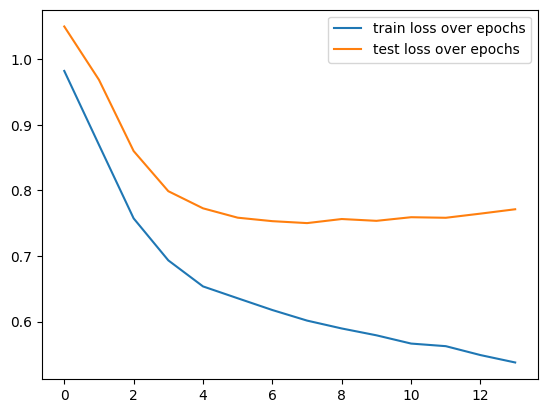

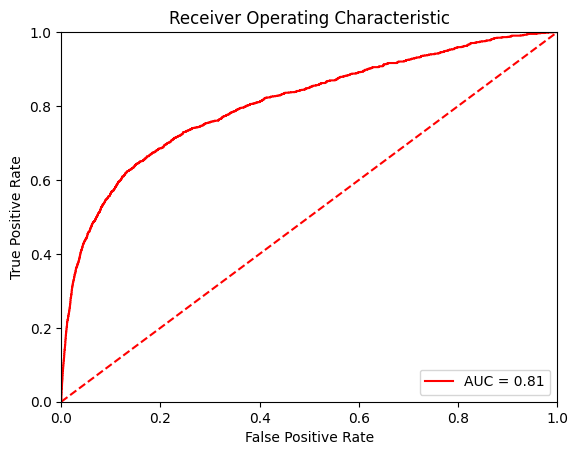

In [19]:
DATASET = 'rigid'
DATA_PATH = f'/home/skrhakv/cryptic-nn/data/{DATASET}'
ESM_EMBEDDINGS_PATH = f'{DATA_PATH}/embeddings'

Xs_train_apo, Ys_train_apo = process_sequence_dataset(f'{DATA_PATH}/train.txt', [ESM_EMBEDDINGS_PATH])
train_dataset_apo = SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo = process_sequence_dataset(f'{DATA_PATH}/test.txt', [ESM_EMBEDDINGS_PATH])
test_dataset_apo = SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo)

model_3 = CryptoBenchClassifier().to(device)
optimizer = torch.optim.Adam(params=model_3.parameters(),
                            lr=0.0001)


fpr_3, tpr_3, roc_auc_3 = train(model_3, optimizer, epochs=14, batch_size=4096, 
      train_dataset=train_dataset_apo, test_dataset=test_dataset_apo)

## Try for YU dataset without multitasking

Concatenating ...
Converting to torch tensor ...
Concatenating ...
Converting to torch tensor ...
Class weights:  tensor([0.5449, 6.0737], device='cuda:0')
Epoch: 0 | Loss: 0.92893, Accuracy: 94.30% | Test loss: 0.86485, AUC: 0.5337117552402121, MCC: 0.0, sum: 0.0
Epoch: 1 | Loss: 0.87267, Accuracy: 94.30% | Test loss: 0.82566, AUC: 0.8254268831612367, MCC: 0.0, sum: 0.0
Epoch: 2 | Loss: 0.80087, Accuracy: 93.94% | Test loss: 0.77468, AUC: 0.8438705621449882, MCC: 0.14113775514349394, sum: 199.0
Epoch: 3 | Loss: 0.73192, Accuracy: 92.58% | Test loss: 0.70820, AUC: 0.8552886107569801, MCC: 0.2115354175540165, sum: 681.0
Epoch: 4 | Loss: 0.65538, Accuracy: 91.21% | Test loss: 0.63633, AUC: 0.8696602233361589, MCC: 0.30501862918385636, sum: 1271.0
Epoch: 5 | Loss: 0.61085, Accuracy: 91.08% | Test loss: 0.56634, AUC: 0.885369769800003, MCC: 0.359519703054639, sum: 1478.0
Epoch: 6 | Loss: 0.58441, Accuracy: 90.27% | Test loss: 0.51058, AUC: 0.8992301404806243, MCC: 0.3895143373684856, sum: 

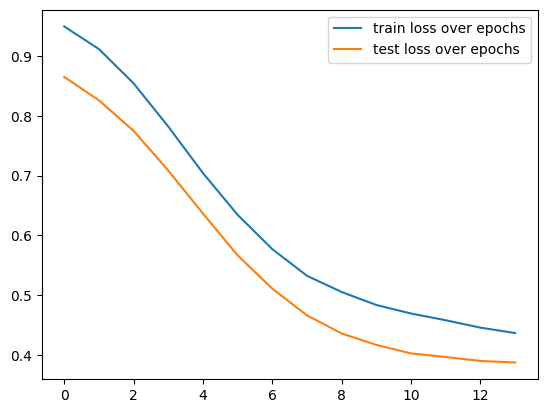

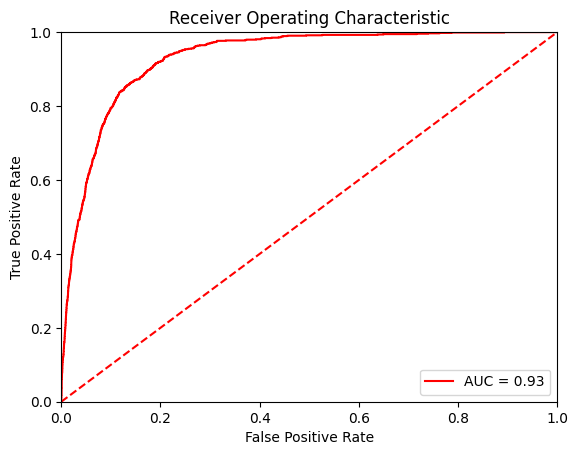

In [6]:
DATASET = 'Yu_DNA'
DATA_PATH = f'/home/skrhakv/cryptic-nn/data/{DATASET}'
ESM_EMBEDDINGS_PATH = f'{DATA_PATH}/embeddings'

def process_sequence_dataset(annotation_path, embeddings_paths):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            sequence = row[4]

            if row[3] == '':
                continue
            
            # load the precomputed embedding
            if id not in Xs:
                for embeddings_path in embeddings_paths:
                    filename = id + '.npy'
                    embedding = np.load(f'{embeddings_path}/{filename}')
                    if id not in Xs:
                        Xs[id] = embedding
                    else:
                        Xs[id] = np.concatenate((Xs[id], embedding), axis = 1)
                    

            # load the annotations denoting whether particular residue is binding or not
            # we use binary annotation: 0=non-binding; 1=binding
            if id not in Ys:
                Ys[id] = np.zeros(embedding.shape[0])
            for (aa, residue_idx) in [(residue[0], int(residue[1:])) for residue in row[3].split(' ')]:
                residue_idx -= 1
                assert sequence[residue_idx] == aa
                Ys[id][residue_idx] = 1

    return Xs, Ys

Xs_train_apo, Ys_train_apo = process_sequence_dataset(f'{DATA_PATH}/train.txt', [ESM_EMBEDDINGS_PATH])
train_dataset_apo = SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo = process_sequence_dataset(f'{DATA_PATH}/test.txt', [ESM_EMBEDDINGS_PATH])
test_dataset_apo = SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo)

model_3 = CryptoBenchClassifier().to(device)
optimizer = torch.optim.Adam(params=model_3.parameters(),
                            lr=0.0001)


fpr_3, tpr_3, roc_auc_3 = train(model_3, optimizer, epochs=14, batch_size=4096, 
      train_dataset=train_dataset_apo, test_dataset=test_dataset_apo)

## Remove non-cryptic binding sites from the evaluation
There are binding sites on the protein that don't exhibit required flexibility to be considered cryptic. Remove those from the evaluation.

In [ ]:
def process_sequence_dataset_without_noncryptic_residues(annotation_path, noncryptic_annotation_path, embeddings_paths):
    Xs = {}
    Ys = {}

    noncryptic_information = {}
    with open(noncryptic_annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            sequence = row[4]

            if row[3] == '':
                continue

            # sanity check
            for (aa, residue_idx) in [(residue[0], int(residue[1:])) for residue in row[3].split(' ')]:
                assert sequence[residue_idx] == aa
            
            noncryptic_information[id] = (row[3], sequence)
    
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            sequence = row[4]

            if row[3] == '':
                continue
            
            # load the precomputed embedding
            if id not in Xs:
                for embeddings_path in embeddings_paths:
                    filename = id + '.npy'
                    embedding = np.load(f'{embeddings_path}/{filename}')
                    if id not in Xs:
                        Xs[id] = embedding
                    else:
                        Xs[id] = np.concatenate((Xs[id], embedding), axis = 1)
                    

            # load the annotations denoting whether particular residue is binding or not
            # we use binary annotation: 0=non-binding; 1=binding
            assert id not in Ys
            Ys[id] = np.zeros(embedding.shape[0])
            for (aa, residue_idx) in [(residue[0], int(residue[1:])) for residue in row[3].split(' ')]:
                assert sequence[residue_idx] == aa
                Ys[id][residue_idx] = 1

            # let's remove the non-cryptic residues from the embedding
            if id in noncryptic_information:
                noncryptic_residues_indices = []
                for (aa, residue_idx) in [(residue[0], int(residue[1:])) for residue in noncryptic_information[id][0].split(' ')]:

                    assert sequence[residue_idx] == aa
                    assert sequence == noncryptic_information[id][1]

                    # residue is annotated as non-cryptic AND not annotated as cryptic -> residue is non-cryptic
                    if Ys[id][residue_idx] == 0:
                        noncryptic_residues_indices.append(residue_idx)

                # remove the non-cryptic residues from the embedding
                Xs[id] = np.delete(Xs[id], noncryptic_residues_indices, axis=0)
                Ys[id] = np.delete(Ys[id], noncryptic_residues_indices, axis=0)

    return Xs, Ys

In [16]:
Xs_train_apo, Ys_train_apo = process_sequence_dataset_without_noncryptic_residues(f'/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', '/home/skrhakv/cryptic-nn/data/non-cryptic-cryptobench/noncryptic-annotations.txt', [ESM_EMBEDDINGS_PATH])
train_dataset_apo = SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo = process_sequence_dataset_without_noncryptic_residues(f'/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', '/home/skrhakv/cryptic-nn/data/non-cryptic-cryptobench/noncryptic-annotations.txt', [ESM_EMBEDDINGS_PATH])
test_dataset_apo = SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo)

Concatenating ...
Converting to torch tensor ...
Concatenating ...
Converting to torch tensor ...


Class weights:  tensor([0.5312, 8.5047], device='cuda:0')
Epoch: 0 | Loss: 1.06573, Accuracy: 94.14% | Test loss: 1.34608, AUC: 0.5603, MCC: 0.0000, F1: 0.9130, AUPRC: 0.0711, sum: 0.0
Epoch: 1 | Loss: 0.91387, Accuracy: 94.21% | Test loss: 0.91695, AUC: 0.8635, MCC: 0.1490, F1: 0.9181, AUPRC: 0.3487, sum: 238.0
Epoch: 2 | Loss: 0.71921, Accuracy: 94.46% | Test loss: 0.85318, AUC: 0.8773, MCC: 0.2786, F1: 0.9279, AUPRC: 0.4046, sum: 720.0
Epoch: 3 | Loss: 0.85427, Accuracy: 94.61% | Test loss: 0.85001, AUC: 0.8786, MCC: 0.3303, F1: 0.9324, AUPRC: 0.4192, sum: 974.0
Epoch: 4 | Loss: 0.83661, Accuracy: 94.65% | Test loss: 0.84914, AUC: 0.8795, MCC: 0.3416, F1: 0.9335, AUPRC: 0.4223, sum: 1032.0
Epoch: 5 | Loss: 0.78936, Accuracy: 94.70% | Test loss: 0.85069, AUC: 0.8796, MCC: 0.3583, F1: 0.9350, AUPRC: 0.4258, sum: 1127.0
Epoch: 6 | Loss: 0.61089, Accuracy: 94.72% | Test loss: 0.85957, AUC: 0.8783, MCC: 0.3588, F1: 0.9350, AUPRC: 0.4299, sum: 1098.0
Epoch: 7 | Loss: 0.66881, Accuracy: 94

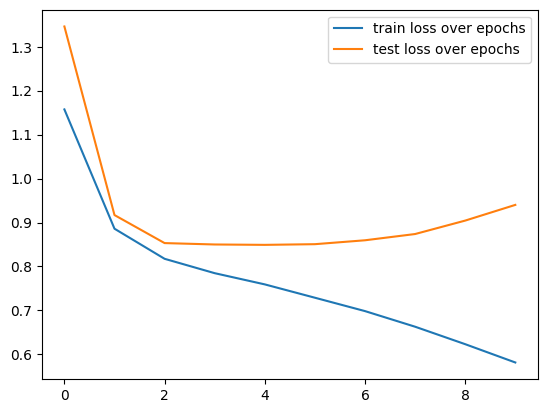

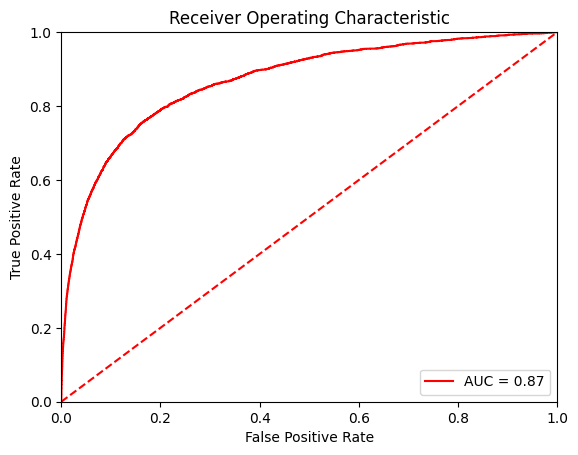

In [ ]:
model_3 = CryptoBenchClassifier().to(device)
optimizer = torch.optim.AdamW(params=model_3.parameters(),
                            lr=0.0001)


fpr_3, tpr_3, roc_auc_3 = train(model_3, optimizer, epochs=10, batch_size=2048, 
      train_dataset=train_dataset_apo, test_dataset=test_dataset_apo)
# Epoch: 3 | Loss: 0.54364, Accuracy: 86.58% | Test loss: 0.59630, AUC: 0.8761860, MCC: 0.37719, sum: 8860.0
# Epoch: 4 | Loss: 0.83661, Accuracy: 94.65% | Test loss: 0.84914, AUC: 0.8795, MCC: 0.3416, F1: 0.9335, AUPRC: 0.4223, sum: 1032.0


## Generate CSV file with predictions
For each residue, generate prediction using the format needed for [this script](https://github.com/podleyan/Near-Hit-Scoring/blob/main/evaluation.py).

In [7]:
OUTPUT_PATH = '/home/skrhakv/cryptic-nn/data/cryptobench/predictions/baseline-nn'

for protein_id in Xs_test_apo.keys():
    X = torch.tensor(Xs_test_apo[protein_id], dtype=torch.float32).to(device)

    test_logits = model_3(X).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    np.save(f'{OUTPUT_PATH}/{protein_id}.npy', test_pred.cpu().detach().numpy())


In [ ]:
# This is how the file should look like (most importantly the 'rep_chain', 'chain', 'resnum', 'resname', 'LIGYSIS', 'predicted_binding' columns):
import pandas as pd
df = pd.read_parquet(f"/home/skrhakv/Near-Hit-Scoring/data/input/predictions/ligysis_predictions_10.parquet")
df.head()

,rep_chain,chain,resnum,resname,LIGYSIS,VN-EGNN,IF-SitePred,GrASP,PUResNet,DeepPocket-Segmented,P2Rank+Cons,P2Rank,fpocket,PocketFinder,Ligsite,Surfnet,pdb_id,file_name,embedding,predicted_binding
0,1a52_A,A,10,LEU,0,0,0,0,0,1,0,0,1,1,0,0,1a52,1a52_A,"[0.034659296, -0.057051137, -0.030547382, 0.04...",0
1,1a52_A,A,11,ALA,0,0,0,0,0,1,0,0,1,1,0,0,1a52,1a52_A,"[0.09474272, 0.1877086, -0.12577535, 0.1178428...",0
2,1a52_A,A,12,LEU,0,0,0,0,0,0,0,0,0,0,0,0,1a52,1a52_A,"[0.034915585, 0.13398825, 0.17189804, -0.02475...",0
3,1a52_A,A,13,SER,0,0,0,0,0,0,0,0,0,0,0,0,1a52,1a52_A,"[0.0376155, 0.2627644, 0.18900742, 0.12767237,...",0
4,1a52_A,A,14,LEU,0,0,0,0,0,1,0,0,1,1,0,0,1a52,1a52_A,"[0.003124461, 0.21869953, 0.15117516, 0.205336...",0


### Generate
Create the CSV file and convert it to pacquet format.

In [12]:
import csv
import pyarrow as pa
import pyarrow.parquet as pq

OUTPUT_PATH = '/home/skrhakv/cryptic-nn/data/cryptobench/predictions/baseline-nn'
CSV_OUTPUT_PATH = '/home/skrhakv/Near-Hit-Scoring/data/input/predictions'

output_file = f"{CSV_OUTPUT_PATH}/cryptobench-baseline.csv"
with open(output_file, mode='w') as file:
    for protein_id in Xs_test_apo.keys():
        writer = csv.writer(file, delimiter=';')
        writer.writerow(['rep_chain', 'chain', 'resnum', 'resname', 'LIGYSIS', 'predicted_binding'])

        pdb_id = protein_id[:4]
        chain = protein_id[4:]  # Extract chain from protein_id
        predictions = np.load(f'{OUTPUT_PATH}/{protein_id}.npy')
        actual_values = Ys_test_apo[protein_id]
        for resnum, (predicted_binding, actual_value) in enumerate(zip(predictions, actual_values)):
            resname = "UNK"  # Placeholder for residue name, replace with actual if available
            rep_chain = f"{pdb_id}_{chain}"
            writer.writerow([rep_chain, chain, resnum, resname, int(actual_value), int(predicted_binding)])

input_file = f"{CSV_OUTPUT_PATH}/cryptobench-baseline.csv"
output_file = f"{CSV_OUTPUT_PATH}/cryptobench-baseline.parquet"
df = pd.read_csv(input_file, delimiter=';')
table = pa.Table.from_pandas(df)
pq.write_table(table, output_file)

In [14]:
df = pd.read_parquet(f"{CSV_OUTPUT_PATH}/cryptobench-baseline.parquet")
df.head(100)

,rep_chain,chain,resnum,resname,LIGYSIS,predicted_binding
0,7qoq_A,A,0,UNK,0,1
1,7qoq_A,A,1,UNK,0,1
2,7qoq_A,A,2,UNK,0,0
3,7qoq_A,A,3,UNK,0,0
4,7qoq_A,A,4,UNK,0,0
...,...,...,...,...,...,...
95,7qoq_A,A,95,UNK,0,0
96,7qoq_A,A,96,UNK,0,1
97,7qoq_A,A,97,UNK,0,0
98,7qoq_A,A,98,UNK,0,0
